In [1]:
import sys
import time
import pickle
from pathlib import Path

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
%matplotlib inline

In [3]:
font = {'family': 'Arial',
        'weight': 'normal',
        'size': 14}
plt.rc('font', **font)

In [4]:
sys.path.append(str(Path().resolve().parent))

In [5]:
from torsion.model import get_model
from torsion.utils.plotting import plot_energy_profile

### Load Training and Test Datasets

In [6]:
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')

### Scale Features

In [7]:
scaler_file = 'scaler.pkl'

In [8]:
with open(scaler_file, 'rb') as fptr:
    scaler = pickle.load(fptr)

In [9]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Load Trained Model

In [10]:
model_file = 'model.h5'

In [11]:
model = tf.keras.models.load_model(model_file)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2930)              861420    
_________________________________________________________________
batch_normalization (BatchNo (None, 2930)              11720     
_________________________________________________________________
dropout (Dropout)            (None, 2930)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1465)              4293915   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1465)              5860      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1465)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 293)               4

### Performance on Training Dataset

In [12]:
y_train_pred = model.predict(X_train).flatten()

# Offset correction
y_train_pred = y_train_pred.reshape((-1, 24))
y_train_pred -= np.expand_dims(y_train_pred.min(axis=1), axis=1)
y_train_pred = y_train_pred.flatten()

In [13]:
r2, _ = pearsonr(y_train, y_train_pred)
rmse  = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae   = mean_absolute_error(y_train, y_train_pred)

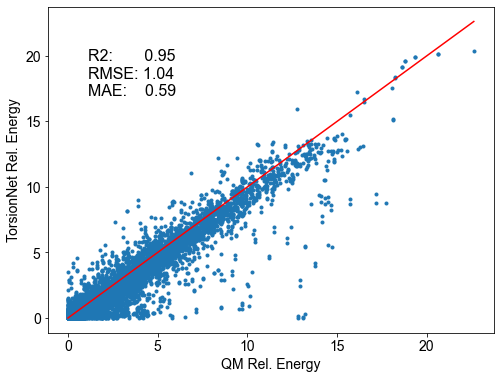

In [14]:
ax_max = max(y_train.max(), y_train_pred.max())

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(y_train, y_train_pred, '.')
ax1.plot([0, ax_max], [0, ax_max], 'r-')
ax1.set_xlabel("QM Rel. Energy")
ax1.set_ylabel("TorsionNet Rel. Energy");
ax1.text(0.05*ax_max, 0.75*ax_max, f'R2:       {r2:.2f}\nRMSE: {rmse:.2f}\nMAE:    {mae:.2f}', fontsize=16);

### Performance on Test Dataset

In [15]:
y_test_pred = model.predict(X_test).flatten()

# Offset correction
y_test_pred = y_test_pred.reshape((-1, 24))
y_test_pred -= np.expand_dims(y_test_pred.min(axis=1), axis=1)
y_test_pred = y_test_pred.flatten()

In [16]:
r2, _ = pearsonr(y_test, y_test_pred)
rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae   = mean_absolute_error(y_test, y_test_pred)

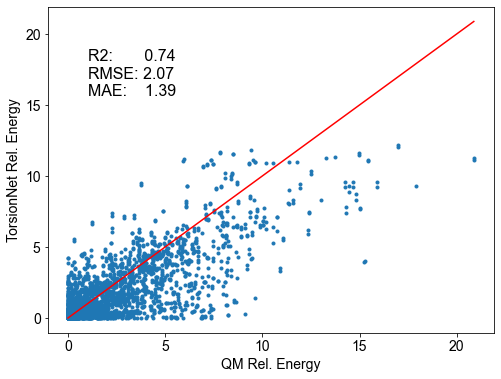

In [17]:
ax_max = max(y_test.max(), y_test_pred.max())

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.plot(y_test, y_test_pred, '.')
ax1.plot([0, ax_max], [0, ax_max], 'r-')
ax1.set_xlabel("QM Rel. Energy")
ax1.set_ylabel("TorsionNet Rel. Energy");
ax1.text(0.05*ax_max, 0.75*ax_max, f'R2:       {r2:.2f}\nRMSE: {rmse:.2f}\nMAE:    {mae:.2f}', fontsize=16);

### Sample Predicted Profiles

In [18]:
y_test_profiles = y_test.reshape(-1, 24)

In [19]:
y_test_profiles_pred = y_test_pred.reshape(-1, 24)

In [20]:
angles = np.linspace(-165, 180, 24)

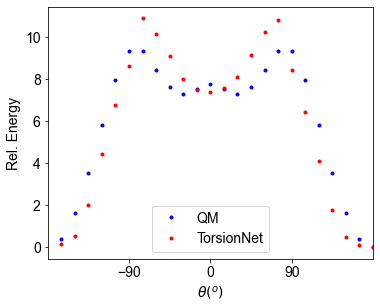

In [21]:
profile_idx = 0


fig = plt.figure(figsize=(2*2.75,2*2.25))
ax = fig.add_subplot(111)
ax.plot(angles, y_test_profiles[profile_idx], 'b.', label='QM')
ax.plot(angles, y_test_profiles_pred[profile_idx], 'r.', label='TorsionNet')
ax.set_xticks([-90, 0, 90])
ax.set_xlim([-180, 180])
ax.set_xlabel(r"$\theta (^o)$")
ax.set_ylabel("Rel. Energy")
ax.legend(loc='best')
fig.tight_layout()